# RMSD analysis
In this notebook we explore the results of the RMSD calculations for phosphorylated and non-phosphorylated

In [8]:
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
from math import log
from scipy.stats import kruskal, pearsonr, ttest_rel, wilcoxon, mannwhitneyu, iqr
from sklearn.metrics import average_precision_score, precision_recall_curve

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

def get_rmsd_summary(df_paths, structure_pair_to_same_author=None):

    rmsd_summary_df = []
    between_medians, within_np_medians, within_p_medians, medians_per_psite = calculate_medians(df_paths, structure_pair_to_same_author)

    columns = ["protein","residue","phosphosite","rmsd_between_groups",
               "rmsd_within_phospho","rmsd_within_nonphospho"]
    for psite, v in medians_per_psite.items():
        protein, residue = psite.split("_")
        between_groups, within_phospho, within_nonphospho = v
        row = [protein, residue, psite, between_groups, within_phospho, within_nonphospho]
        rmsd_summary_df.append(row)

    rmsd_summary_df = pd.DataFrame(rmsd_summary_df, columns=columns)
    return rmsd_summary_df


def calculate_medians(df_paths, structure_pair_to_same_author):
    
    between_medians = []
    within_np_medians = []
    within_p_medians = []
    
    medians_per_psite = {}
    
    for rmsd_df in df_paths:
        psite = rmsd_df.parts[-2]
        df = pd.read_csv(rmsd_df,dtype={"PDB_ID_A":str,"PDB_ID_B":str,
                                        "Chain_A":str, "Chain_B":str})
        
        df["structure_a"] = df["PDB_ID_A"] + "_" + df["Chain_A"]
        df["structure_b"] = df["PDB_ID_B"] + "_" + df["Chain_B"]

        if structure_pair_to_same_author:
            drop_idxs = []
            for idx, row in df.iterrows():
                structure_a = row["structure_a"]
                structure_b = row["structure_b"]
                same_author = structure_pair_to_same_author[(structure_a, structure_b)]
                if same_author == 1:
                    drop_idxs.append(idx)
            df = df.drop(index=drop_idxs)
        
        btwn = df[df["Group"] == "between_groups"]
            
        btwn_rmsd = btwn["RMSD"].values
        between_medians.append(np.nanmedian(btwn_rmsd))

        within_np = df[df["Group"] == "within_nonphospho"]
        within_np_rmsd = within_np["RMSD"].values
        within_np_medians.append(np.nanmedian(within_np_rmsd))

        within_p = df[df["Group"] == "within_phospho"]
        within_p_rmsd = within_p["RMSD"].values
        within_p_medians.append(np.nanmedian(within_p_rmsd))
        
        medians_per_psite[psite] = (np.nanmedian(btwn_rmsd),np.nanmedian(within_p_rmsd),np.nanmedian(within_np_rmsd))
    
    return between_medians, within_np_medians, within_p_medians, medians_per_psite


def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

out_path = Path("backbone_comparison")
out_path.mkdir(exist_ok=True)


In [9]:
# RMSDs on whole structures
rmsds_path = Path("../../results/rmsds")
# RMSDs on protein domains
domain_rmsds_path = Path("../results/domain_rmsds")


rmsd_dfs = list(rmsds_path.glob('**/rmsds_df.csv'))
domain_rmsd_dfs = list(domain_rmsds_path.glob("**/rmsds_df.csv"))
rmsd_summary_df = get_rmsd_summary(rmsd_dfs)

domain_rmsd_summary_df = get_rmsd_summary(domain_rmsd_dfs)
rmsd_summary_df.to_csv(rmsds_path / "rmsd_summary.csv")
domain_between_medians, domain_within_dp_medians, domain_within_p_medians, domain_medians_per_psite = calculate_medians(domain_rmsd_dfs,False)


In [26]:
rmsd_summary_df_nodups = rmsd_summary_df.round(decimals=4).drop_duplicates(subset=list(rmsd_summary_df.columns)[3:])
tmp_rmsd_df = rmsd_summary_df.drop(["protein","residue","phosphosite"],axis=1)
rmsd_duplicate_rows = rmsd_summary_df[tmp_rmsd_df.duplicated(keep=False)]

single_phospho = []
for idx in rmsd_summary_df.index:
    if idx in rmsd_duplicate_rows.index:
        single_phospho.append('multiple')
    else:
        single_phospho.append('single')

rmsd_summary_df['is_single_phospho'] = single_phospho

In [ ]:
rmsd_summary_df_nodups.to_csv("rmsd_summary_df_nodups.csv")

### RMSD differences using whole chains

In [17]:
color_palette=[sns.color_palette("Set1")[2],sns.color_palette("Set1")[4],sns.color_palette("Set1")[1]]

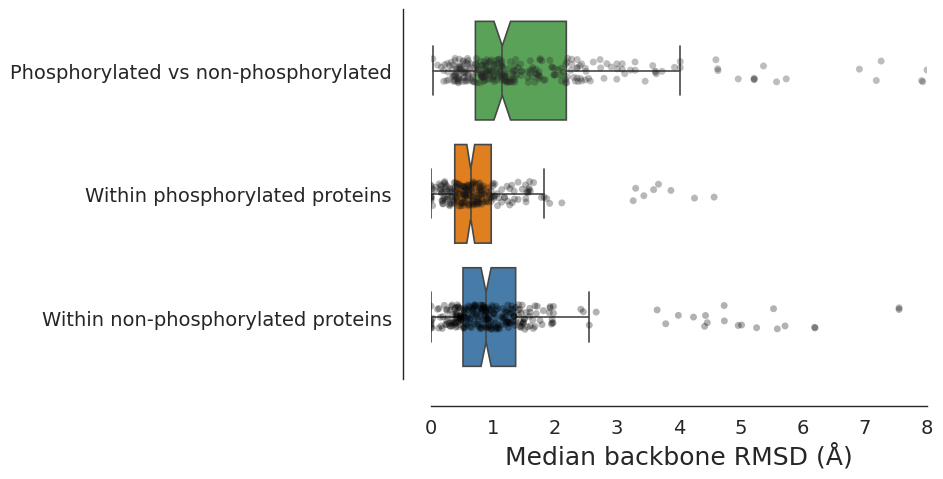

In [28]:
# Boxplot with all comparisons
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})
ax = sns.boxplot(data=rmsd_summary_df_nodups, orient="h", notch=True, showfliers = False,palette=color_palette)
ax = sns.stripplot(data=rmsd_summary_df_nodups, orient="h",palette='dark:black',alpha=0.3,jitter=True)

ax.set_yticklabels(["Phosphorylated vs non-phosphorylated","Within phosphorylated proteins","Within non-phosphorylated proteins"])
ax.set_xlabel("Median backbone RMSD (Å)",fontsize=18)

plt.xlim(0,8)
sns.despine(offset=20)
plt.savefig(out_path / "boxplot_groups.pdf",dpi=150,bbox_inches='tight')

### What is the median RMSD upon phosphorylation?

In [31]:
median_rmsd_change = rmsd_summary_df_nodups["rmsd_between_groups"].median()
std_rmsd_change = rmsd_summary_df_nodups["rmsd_between_groups"].std()
print(f"Median RMSD change {median_rmsd_change:3f}, stdev {std_rmsd_change:3f}")

Median RMSD change 1.148500, stdev 3.129709


### What fraction of changes are above 2 angstroms?

In [32]:
rmsd_summary_df_nodups_abovecutoff = rmsd_summary_df_nodups.loc[rmsd_summary_df_nodups["rmsd_between_groups"]>=2]
frac_above_2 = len(rmsd_summary_df_nodups_abovecutoff)/len(rmsd_summary_df_nodups)
print(f"{100*frac_above_2:.3f}% are above 2 angstroms")


28.136% are above 2 angstroms


### Plot changes between groups

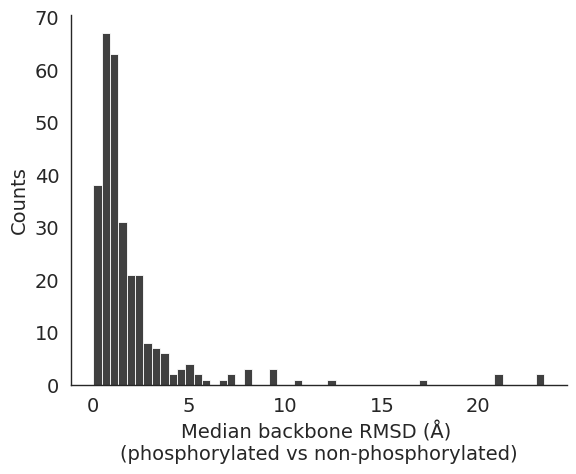

In [15]:
# Plot concordance between groups as a histogram
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

sns.histplot(rmsd_summary_df_nodups["rmsd_between_groups"],color='black')
plt.xlabel("Median backbone RMSD (Å) \n(phosphorylated vs non-phosphorylated)", fontsize=14)
plt.ylabel("Counts", fontsize=14)
sns.despine()
plt.savefig(out_path / "histogram_between_rmsds.png",dpi=150,bbox_inches='tight')


In [16]:
rmsd_summary_df_nodups_nona = rmsd_summary_df_nodups.dropna()
smaller_in_phospho = sum(rmsd_summary_df_nodups_nona["rmsd_within_phospho"] < rmsd_summary_df_nodups_nona["rmsd_within_nonphospho"])

print("In what fraction is the phospho RMSD smaller?")
print(smaller_in_phospho / len(rmsd_summary_df_nodups_nona))

In what fraction is the phospho RMSD smaller?
0.649746192893401


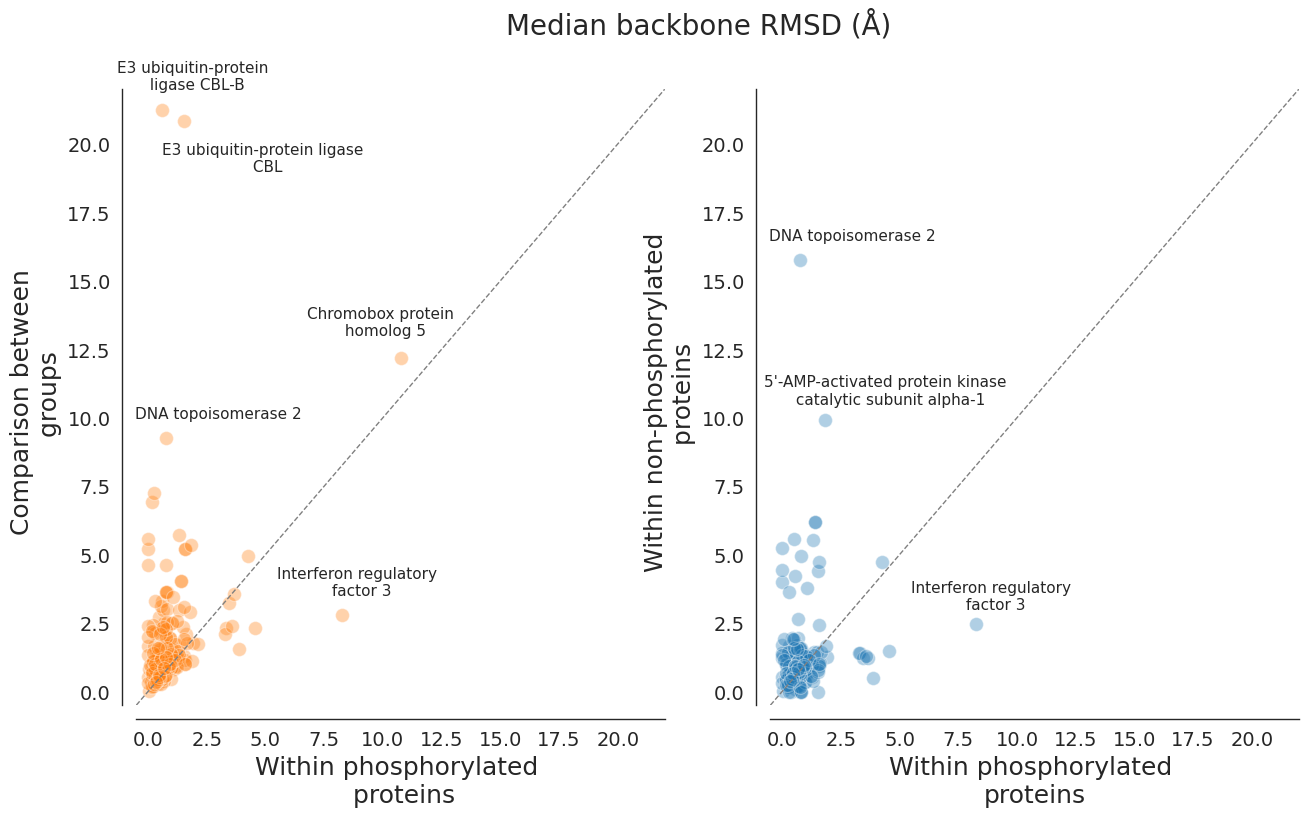

In [17]:
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(data=rmsd_summary_df_nodups, x="rmsd_within_phospho",y="rmsd_between_groups",alpha=0.35,c="tab:orange",s=100,ax=axs[0])
add_identity(axs[0], color='gray', ls='--', lw=1)
axs[0].set_ylabel("Comparison between \n groups",fontsize=18)
axs[0].set_xlabel("Within phosphorylated \n proteins",fontsize=18)
axs[0].set_xlim(-.5,22)
axs[0].set_ylim(-.5,22)

sns.scatterplot(data=rmsd_summary_df_nodups, x="rmsd_within_phospho",y="rmsd_within_nonphospho",alpha=0.35,c="tab:blue",s=100,ax=axs[1])
add_identity(axs[1], color='gray', ls='--', lw=1)
axs[1].set_ylabel("Within non-phosphorylated \n proteins",fontsize=18)
axs[1].set_xlabel("Within phosphorylated \nproteins",fontsize=18)
axs[1].set_xlim(-.5,22)
axs[1].set_ylim(-.5,22)

sns.despine(offset=10)

plt.suptitle("Median backbone RMSD (Å)",fontsize=20)
plt.savefig(out_path / "scatter_rmsd_phospho_vs_between.png",dpi=150, bbox_inches='tight')


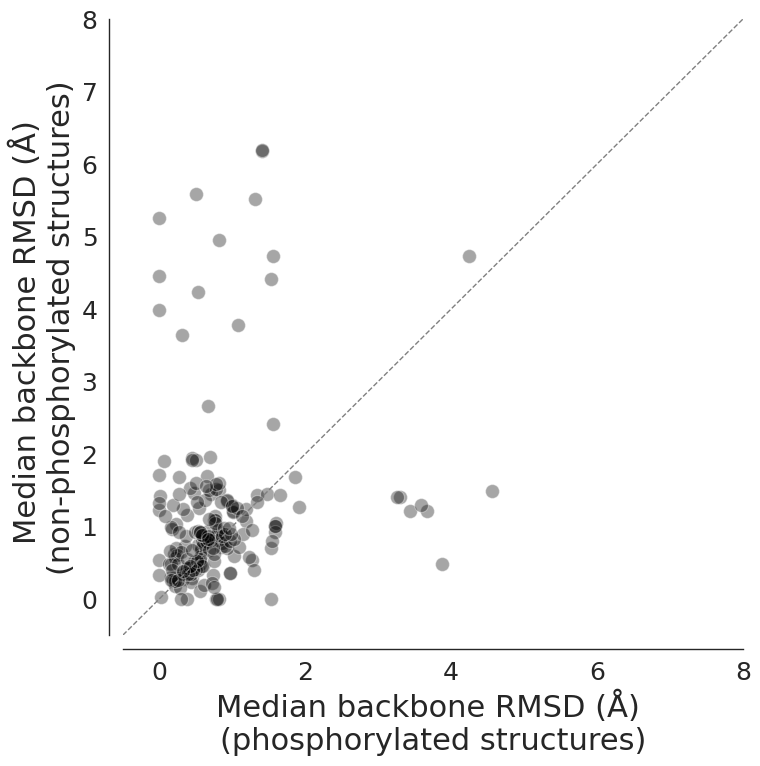

In [18]:
fig = plt.figure(figsize=(8,8))
sns.set_context('paper',rc={"xtick.labelsize":18,"ytick.labelsize":18})

axs = sns.scatterplot(data=rmsd_summary_df_nodups_nona, x="rmsd_within_phospho",y="rmsd_within_nonphospho",
                alpha=0.35,c="black",s=100)
add_identity(axs, color='gray', ls='--', lw=1)
plt.ylabel("Median backbone RMSD (Å) \n(non-phosphorylated structures)",fontsize=22)
plt.xlabel("Median backbone RMSD (Å) \n(phosphorylated structures)",fontsize=22)
plt.xlim(-.5,8)
plt.ylim(-.5,8)

sns.despine(offset=10)
plt.savefig(out_path / "scatter_rmsd_phospho_vs_nonphospho.pdf",dpi=150, bbox_inches='tight')


## Are there statistically significant differences between the groups?
Yes, absolutely!

In [19]:
rmsd_summary_df_all_nona = rmsd_summary_df_nodups[["rmsd_between_groups", "rmsd_within_phospho", "rmsd_within_nonphospho"]].dropna()
rmsd_summary_df_nona = rmsd_summary_df_nodups[["rmsd_within_phospho","rmsd_within_nonphospho"]].dropna()

In [20]:
mwu_stat_np_between, mwu_pval_np_between = mannwhitneyu(rmsd_summary_df_all_nona["rmsd_between_groups"],rmsd_summary_df_all_nona["rmsd_within_nonphospho"],alternative='greater')
mwu_stat_p_between, mwu_pval_p_between = mannwhitneyu(rmsd_summary_df_all_nona["rmsd_between_groups"],rmsd_summary_df_all_nona["rmsd_within_phospho"],alternative='greater')

In [21]:
adj_pvals = multipletests([mwu_pval_np_between, mwu_pval_p_between], alpha=0.05, method='fdr_bh')
print(adj_pvals)

(array([ True,  True]), array([1.12559483e-04, 1.79848433e-14]), 0.025320565519103666, 0.025)


In [22]:
wilcox_stat, wilcox_pval = wilcoxon(rmsd_summary_df_nona["rmsd_within_phospho"],rmsd_summary_df_nona["rmsd_within_nonphospho"],alternative='less')
print(wilcox_stat, wilcox_pval)


5993.5 4.850112839952845e-06


/local/home/mcorrea/miniconda3/envs/general/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


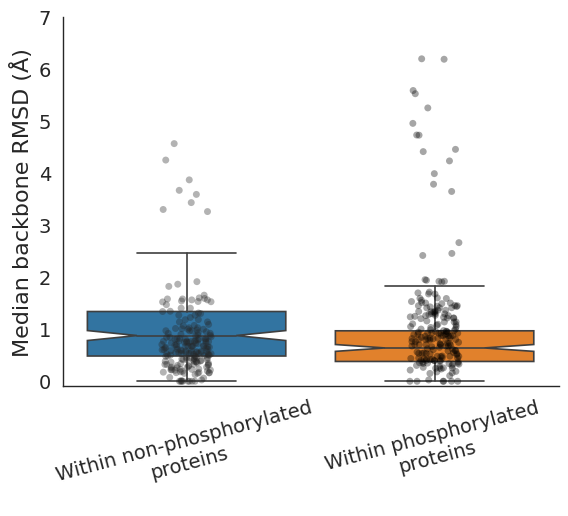

In [23]:
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

ax = sns.boxplot(rmsd_summary_df_nona[["rmsd_within_phospho","rmsd_within_nonphospho"]],showfliers=False,
            order=["rmsd_within_nonphospho","rmsd_within_phospho"], notch=True)
sns.stripplot(rmsd_summary_df_nona[["rmsd_within_phospho","rmsd_within_nonphospho"]],color='black',alpha=.35)
sns.despine()
plt.ylabel("Median backbone RMSD (Å)",fontsize=16)
ax.set_xticklabels(["Within non-phosphorylated\nproteins","Within phosphorylated\nproteins"],rotation=15,fontsize=14)

plt.ylim(-0.1,7)

sns.despine()

plt.savefig(out_path / "boxplot_rmsd_phospho_vs_nonphospho.pdf",dpi=120,bbox_inches='tight')

# Does the phosphosite residue play a role?


In [27]:
print("How many unique phosphosites do we have RMSDs for?")
print(len(rmsd_summary_df_nodups["phosphosite"].unique()))

How many unique phosphosites do we have RMSDs for?
290


In [28]:
pdb_pairs_df = pd.read_csv("/local/home/mcorrea/Documents/controlphospho/data/processed/pdb_pairs/filtered_df.csv")

In [29]:
pdb_pairs_df["phosphosite"] = pdb_pairs_df["UNIPROT"] + "_" + pdb_pairs_df["UNIPROT_RESIDUE_NUMBER"].astype(str)
print("How many unique phosphosites?")
print(len(pdb_pairs_df["phosphosite"].unique()))
# Remove all columns except the one with the phosphosite ID and the residue in the non-phosphorylated structure
subset_df = pdb_pairs_df[["phosphosite","CHEM_COMP_ONE"]]
subset_df = subset_df.drop_duplicates()

#P00634_124 -> should be SER, drop 27696
#P20906_26 -> should be SER, drop 1777
subset_df = subset_df.drop(index=[27696, 1777])

How many unique phosphosites?
347


In [30]:
# Remove multisite phosphorylations
rmsd_merged_df = rmsd_summary_df.merge(subset_df, on="phosphosite")
rmsd_merged_df = rmsd_merged_df.loc[rmsd_merged_df["is_single_phospho"] == "single"]
rmsd_merged_df.to_csv(out_path / "rmsd_merged_df.csv",index=None)


/tmp/ipykernel_203557/277424351.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=rmsd_merged_df, x="rmsd_between_groups",y="CHEM_COMP_ONE",


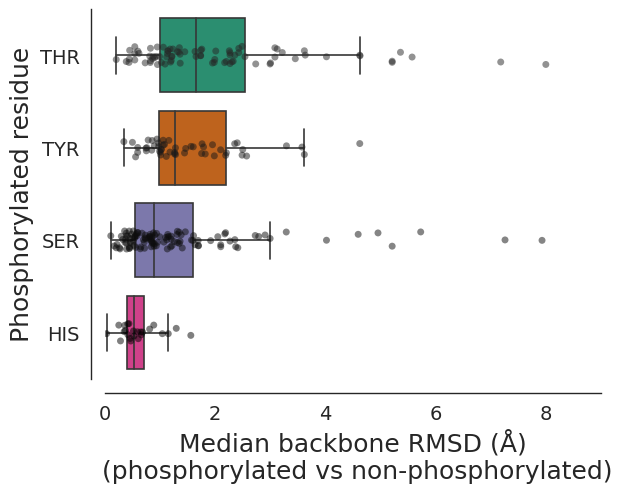

In [32]:
# TODO: can differences be explained by a bias? E.g. "homologous" phosphosites
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})
ax = sns.boxplot(data=rmsd_merged_df, x="rmsd_between_groups",y="CHEM_COMP_ONE",showfliers = False,
                 order=["THR","TYR","SER","HIS"], palette="Dark2")


ax = sns.stripplot(data=rmsd_merged_df, x="rmsd_between_groups",y="CHEM_COMP_ONE",
                  palette='dark:black',alpha=0.5,jitter=True,order=["THR","TYR","SER","HIS"])

plt.xlim(0,9)
sns.despine(offset=10)
plt.xlabel("Median backbone RMSD (Å)\n (phosphorylated vs non-phosphorylated)",fontsize=18)
plt.ylabel("Phosphorylated residue",fontsize=18)

plt.savefig(out_path / "rmsd_by_residue.pdf",dpi=150, bbox_inches='tight')


In [33]:
group_thr = rmsd_merged_df.loc[rmsd_merged_df["CHEM_COMP_ONE"]=="THR"]["rmsd_between_groups"]
group_ser = rmsd_merged_df.loc[rmsd_merged_df["CHEM_COMP_ONE"]=="SER"]["rmsd_between_groups"]
group_tyr = rmsd_merged_df.loc[rmsd_merged_df["CHEM_COMP_ONE"]=="TYR"]["rmsd_between_groups"]
group_his = rmsd_merged_df.loc[rmsd_merged_df["CHEM_COMP_ONE"]=="HIS"]["rmsd_between_groups"]

In [ ]:
print(group_ser.median(), group_ser.std())
print(group_thr.median(), group_thr.std())
print(group_tyr.median(), group_tyr.std())
print(group_his.median(), group_his.std())

In [36]:
# No post-hocs test in Python, do it in R
kruskal(group_thr, group_ser, group_tyr, group_his)

KruskalResult(statistic=49.52260834383667, pvalue=1.0096300666723945e-10)

# Functional scores
Are phosphosites predicted to be functional associated with larger conformational changes? Yes!
As a predictor by itself, though, it's pretty bad!

In [37]:
functional_scores_df = pd.read_csv("../data/processed/functional_scores/functional_scores.csv")
merged_scores_df = rmsd_summary_df.merge(functional_scores_df, on="phosphosite")
merged_scores_df_single = merged_scores_df.loc[merged_scores_df["is_single_phospho"]=="single"]

In [38]:
is_score_above_cutoff = []
for value in merged_scores_df_single["functional_score"]:
    if value >= 0.5:
        is_score_above_cutoff.append("True")
    else:
        is_score_above_cutoff.append("False")
merged_scores_df_single['is_score_above_cutoff'] = is_score_above_cutoff

/tmp/ipykernel_203557/436622623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_scores_df_single['is_score_above_cutoff'] = is_score_above_cutoff


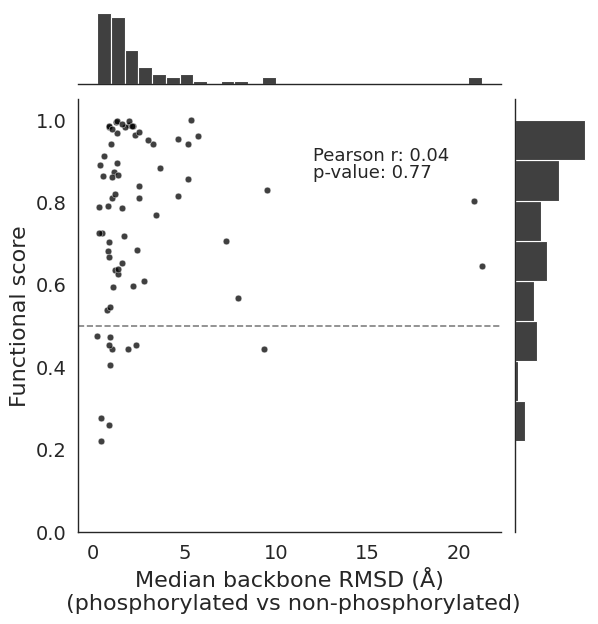

In [39]:
rmsd_func_corr, rmsd_func_pval = pearsonr(merged_scores_df_single["rmsd_between_groups"],merged_scores_df_single["functional_score"])

sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})
sns.jointplot(data=merged_scores_df_single,x="rmsd_between_groups",y="functional_score",alpha=.75,color='black')

plt.ylim(0,1.05)
plt.axhline(0.5,color='gray',ls='--')
#plt.xlim(0,20)

plt.text(12,0.9,f"Pearson r: {rmsd_func_corr:.2f}",fontsize=13)
plt.text(12,0.86,f"p-value: {rmsd_func_pval:.2f}",fontsize=13)


plt.ylabel("Functional score",fontsize=16)
plt.xlabel("Median backbone RMSD (Å)\n (phosphorylated vs non-phosphorylated)",fontsize=16)
plt.savefig(out_path/"functional_score_vs_between_rmsd.png",dpi=200,bbox_inches='tight')

In [40]:
above_cutoff = merged_scores_df_single.loc[merged_scores_df_single["is_score_above_cutoff"]=="True"]["rmsd_between_groups"]
below_cutoff = merged_scores_df_single.loc[merged_scores_df_single["is_score_above_cutoff"]=="False"]["rmsd_between_groups"]

mannwhitneyu(above_cutoff, below_cutoff,alternative='greater')

MannwhitneyuResult(statistic=456.5, pvalue=0.02262145788676913)

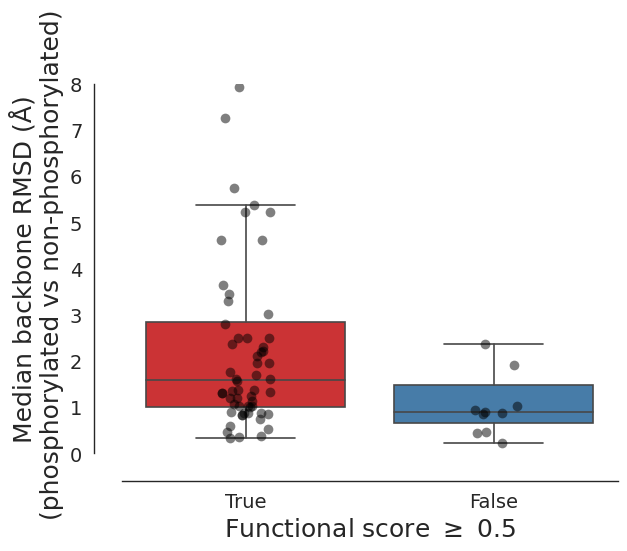

In [42]:
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

sns.boxplot(data=merged_scores_df_single,y="rmsd_between_groups",x="is_score_above_cutoff",showfliers=False,palette="Set1")
sns.stripplot(data=merged_scores_df_single,y="rmsd_between_groups",x="is_score_above_cutoff",color='black',
              dodge=True,jitter=True,alpha=0.5,size=7)

plt.ylim(0,8)

plt.xlabel("Functional score $\geq$ 0.5",fontsize=18)
plt.ylabel("Median backbone RMSD (Å)\n (phosphorylated vs non-phosphorylated)",fontsize=18)

sns.despine(offset=20)
plt.savefig(out_path / "boxplot_rmsd_vs_functional_score.pdf",dpi=120,bbox_inches='tight')

# Comparisons per domain
Here, we compare the RMSD within Pfam domains to the RMSD within whole proteins

In [44]:
col_mapper = {"rmsd_between_groups":"domain_rmsd_between_groups",
              "rmsd_within_phospho":"domain_rmsd_within_phospho",
              "rmsd_within_nonphospho":"domain_rmsd_within_nonphospho"}
domain_rmsd_summary_df = domain_rmsd_summary_df.rename(mapper=col_mapper,axis=1)


In [45]:
domain_rmsd_summary_df

,protein,residue,phosphosite,domain_rmsd_between_groups,domain_rmsd_within_phospho,domain_rmsd_within_nonphospho
0,Q9H8S9,35,Q9H8S9_35,1.076434,NaN,1.334625
1,P24941,15,P24941_15,2.480343,2.480343,2.480343
2,Q92630,458,Q92630_458,0.839915,0.736044,0.743931
3,Q9L387,85,Q9L387_85,0.389270,NaN,0.417414
4,Q9F4L3,28,Q9F4L3_28,0.205533,0.275132,0.130732
...,...,...,...,...,...,...
222,Q94F62,455,Q94F62_455,2.260568,0.516237,0.754649
223,P11309,276,P11309_276,0.426559,NaN,0.493072
224,P39984,34,P39984_34,0.291902,NaN,0.105760
225,P49759,341,P49759_341,0.864897,0.661650,0.772059


In [46]:
# Remove duplicates (multisite phosphos)
domain_rmsd_summary_df_nodups = domain_rmsd_summary_df.round(decimals=4).drop_duplicates(subset=list(domain_rmsd_summary_df.columns)[3:])
domain_tmp_rmsd_df = domain_rmsd_summary_df.drop(["protein","residue","phosphosite"],axis=1)
domain_rmsd_duplicate_rows = domain_rmsd_summary_df[tmp_rmsd_df.duplicated(keep=False)]

single_phospho = []
for idx in domain_rmsd_summary_df.index:
    if idx in domain_rmsd_duplicate_rows.index:
        single_phospho.append('multiple')
    else:
        single_phospho.append('single')

domain_rmsd_summary_df['is_single_phospho'] = single_phospho

/tmp/ipykernel_203557/513492850.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  domain_rmsd_duplicate_rows = domain_rmsd_summary_df[tmp_rmsd_df.duplicated(keep=False)]


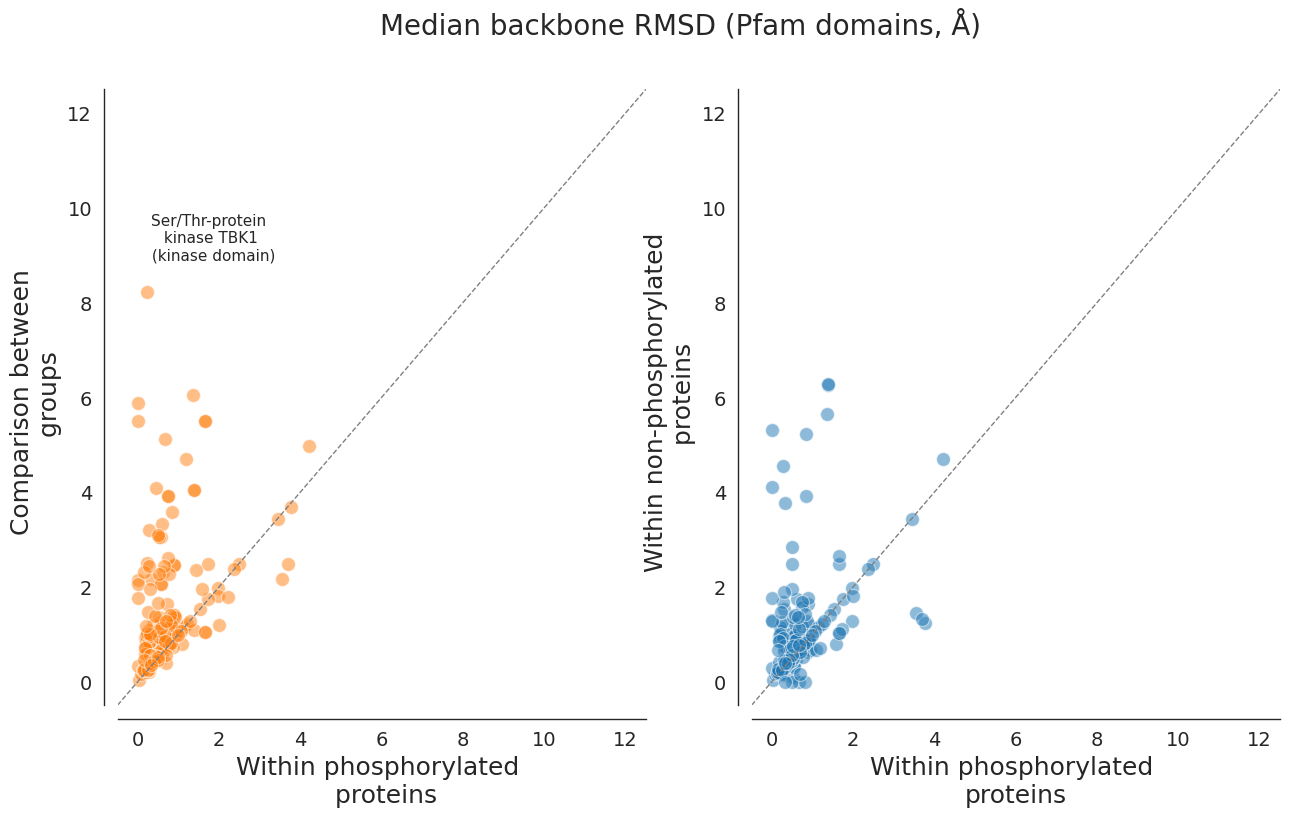

In [48]:
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})

fig, axs = plt.subplots(1,2, figsize=(15,8))

sns.scatterplot(data=domain_rmsd_summary_df_nodups, x="domain_rmsd_within_phospho",y="domain_rmsd_between_groups",alpha=0.5,c="tab:orange",s=100,ax=axs[0])
add_identity(axs[0], color='gray', ls='--', lw=1)
axs[0].set_ylabel("Comparison between \n groups",fontsize=18)
axs[0].set_xlabel("Within phosphorylated \n proteins",fontsize=18)
axs[0].set_xlim(-.5,12.5)
axs[0].set_ylim(-.5,12.5)

# Outliers
axs[0].text(1.8,8.9,"Ser/Thr-protein \n kinase TBK1 \n (kinase domain)",fontsize=11,horizontalalignment='center')

sns.scatterplot(data=domain_rmsd_summary_df_nodups, x="domain_rmsd_within_phospho",y="domain_rmsd_within_nonphospho",alpha=0.5,c="tab:blue",s=100,ax=axs[1])
add_identity(axs[1], color='gray', ls='--', lw=1)
axs[1].set_ylabel("Within non-phosphorylated \n proteins",fontsize=18)
axs[1].set_xlabel("Within phosphorylated \nproteins",fontsize=18)
axs[1].set_xlim(-.5,12.5)
axs[1].set_ylim(-.5,12.5)

sns.despine(offset=10)

plt.suptitle("Median backbone RMSD (Pfam domains, Å)",fontsize=20)

plt.savefig(out_path / "scatter_domain_rmsd_phospho_vs_between.png",dpi=150, bbox_inches='tight')


In [49]:
# Merge domain RMSD dataframe with whole protein RMSD dataframe
merged_rmsd_df = domain_rmsd_summary_df_nodups.merge(rmsd_summary_df_nodups,on="phosphosite",how='left')


In [51]:
# Calculate size ratio between phosphorylated and non-phosphorylated protein
domain_coverage_df = pd.read_csv("../data/processed/pdb_pairs/extracted_domains/domain_coverage.csv")
domain_coverage_df["structure/domain"] = 1/domain_coverage_df["Domain/structure"]
domain_coverage_df = domain_coverage_df.rename({"Phosphosite":"phosphosite"},axis=1)


In [53]:
# # Exclude examples where the domain coverage is less than 3/4ths
psites = list(merged_rmsd_df["phosphosite"])
domain_coverage_df = domain_coverage_df.loc[domain_coverage_df["phosphosite"].isin(psites)]
#merged_rmsd_cov_df = merged_rmsd_df.merge(domain_coverage_df,on="phosphosite",how='left')

In [54]:
# Calculate the median size relationship between the whole structure and the domain
median_fold_size_df = []
columns = ["phosphosite","median structure/domain"]
for psite in psites: 
    subset_df = domain_coverage_df.loc[domain_coverage_df["phosphosite"]==psite]
    median = subset_df["structure/domain"].median()
    median_fold_size_df.append([psite,median])
median_fold_size_df = pd.DataFrame(median_fold_size_df,columns=columns)

In [55]:
median_fold_size_df

,phosphosite,median structure/domain
0,Q9H8S9_35,1.341090
1,P24941_15,1.583034
2,Q92630_458,1.361022
3,Q9L387_85,2.177233
4,Q9F4L3_28,5.245690
...,...,...
201,Q94F62_455,1.287823
202,P11309_276,1.583333
203,P39984_34,7.542857
204,P49759_341,1.496835


In [56]:
merged_rmsd_df = merged_rmsd_df.merge(median_fold_size_df,on="phosphosite",how='left')

In [57]:
# Only take into account examples where the whole structure is at least twice as big as the domain
filtered_merged_rmsd_df = merged_rmsd_df.loc[(merged_rmsd_df["median structure/domain"] >= 2) & (merged_rmsd_df["median structure/domain"] < 100)]

In [58]:
# Ensure there are no duplicates
filtered_merged_rmsd_df = filtered_merged_rmsd_df.drop_duplicates()

In [59]:
filtered_merged_rmsd_df_corr = filtered_merged_rmsd_df[["domain_rmsd_between_groups","rmsd_between_groups"]].dropna()
pearson_corr, p_val = pearsonr(filtered_merged_rmsd_df_corr["domain_rmsd_between_groups"],filtered_merged_rmsd_df_corr["rmsd_between_groups"])
print(pearson_corr, p_val)

0.4450954287070634 0.0005877195357227786


In [60]:
dom_wilcox_stat, dom_wilcox_pval = wilcoxon(filtered_merged_rmsd_df_corr["domain_rmsd_between_groups"],filtered_merged_rmsd_df_corr["rmsd_between_groups"])
print(dom_wilcox_stat, dom_wilcox_pval)

309.0 6.639973856155532e-05


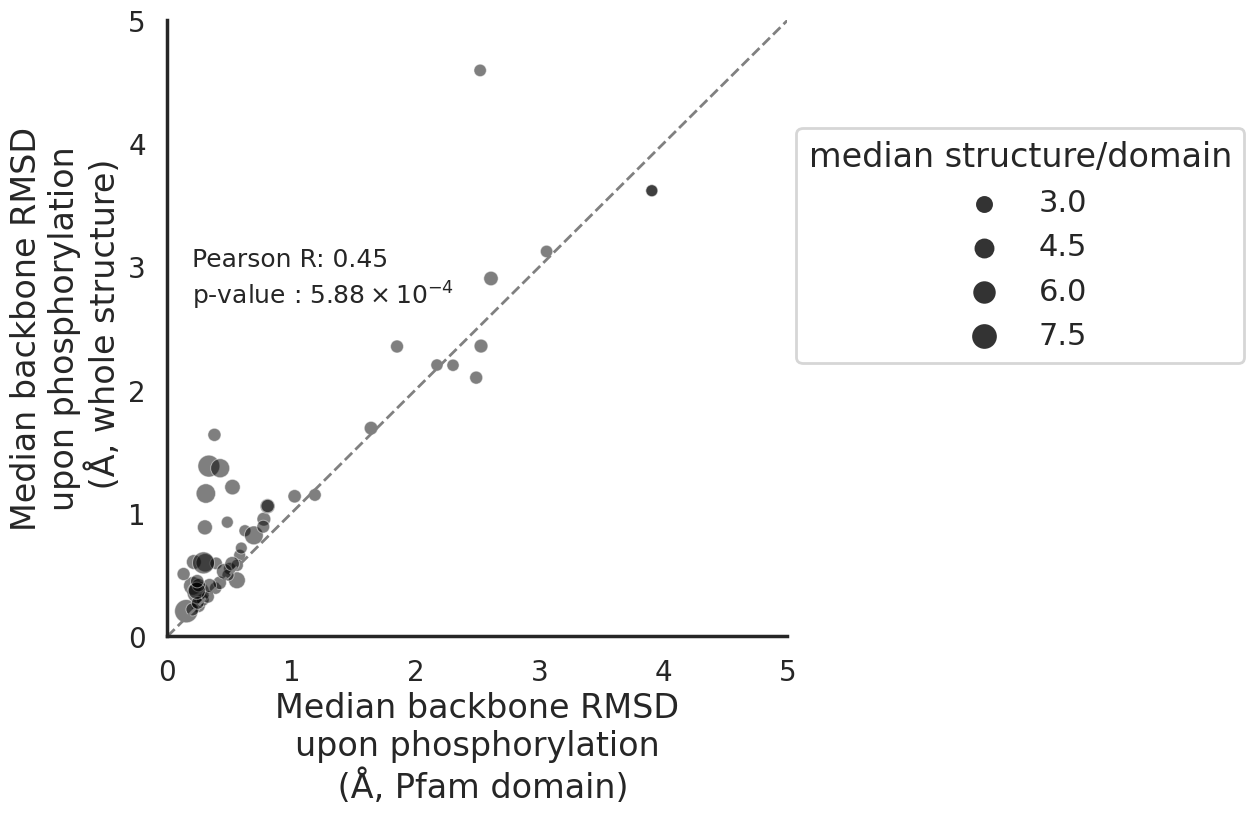

In [61]:
#sns.set_context('poster')
sns.set_style('white')
sns.set_context('poster',rc={"xtick.labelsize":20,"ytick.labelsize":20})

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax = sns.scatterplot(data=filtered_merged_rmsd_df,x="domain_rmsd_between_groups",y="rmsd_between_groups",
                     size="median structure/domain",alpha=.5, color="black")
add_identity(ax, color='gray', ls='--', lw=2)
sns.move_legend(ax, "best",bbox_to_anchor=(.99, .85))

# plt.text(15,10,"DNA-dependent protein \nkinase catalytic subunit \n(DNA-PKcs, CC5)",fontsize=10)
# plt.text(1,22,"E3 ubiquitin-protein ligase \nparkin (ubiquitin family)",fontsize=10)

plt.xlabel('Median backbone RMSD\nupon phosphorylation\n (Å, Pfam domain)',fontsize=24)
plt.ylabel('Median backbone RMSD\nupon phosphorylation\n (Å, whole structure)',fontsize=24)
sns.despine()

plt.text(0.2,3,f"Pearson R: {pearson_corr:.2f}",fontsize=18)
plt.text(0.2,2.7,r"p-value : ${0:s}$".format(as_si(p_val,2)),fontsize=18)
#plt.text(0.2,11,r"p-value: {p_val:.2f}",fontsize=12)

plt.xlim(0,5)
plt.ylim(0,5)

plt.savefig(out_path / "rmsd_domain_vs_whole_structure.pdf",dpi=120,bbox_inches='tight')

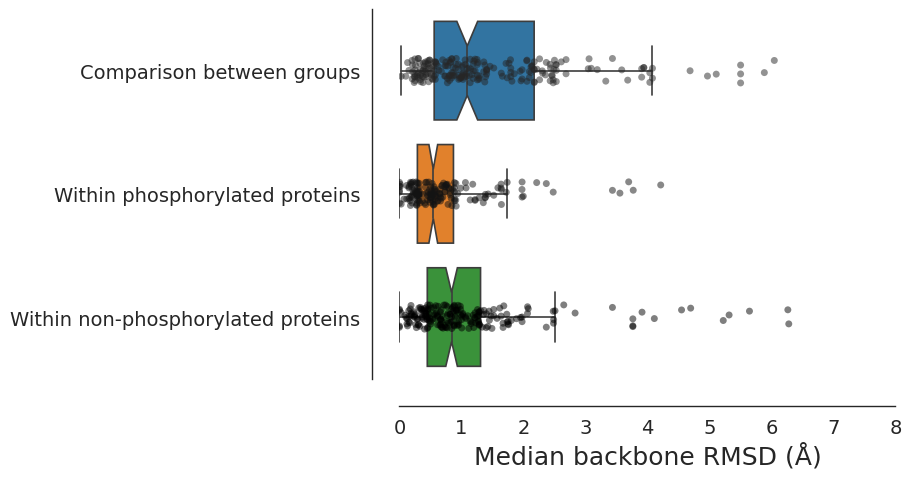

In [72]:
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})
ax = sns.boxplot(data=domain_rmsd_summary_df,orient="h", notch=True, showfliers = False)
ax = sns.stripplot(data=domain_rmsd_summary_df,orient="h",palette='dark:black',alpha=0.5,jitter=True)

ax.set_yticklabels(["Comparison between groups","Within phosphorylated proteins","Within non-phosphorylated proteins"])
ax.set_xlabel("Median backbone RMSD (Å)",fontsize=18)

plt.xlim(0,8)
sns.despine(offset=20)
plt.savefig(out_path / "domain_boxplot_groups.png",dpi=150,bbox_inches='tight')

In [195]:
merged_rmsd_summary_df_between_p = filtered_merged_rmsd_df[["rmsd_between_groups", "rmsd_within_phospho"]].dropna()
merged_rmsd_summary_df_between_np = filtered_merged_rmsd_df[["rmsd_between_groups", "rmsd_within_nonphospho"]].dropna()
merged_rmsd_summary_df_p_np = filtered_merged_rmsd_df[["rmsd_within_phospho","rmsd_within_nonphospho"]].dropna()


In [201]:
mwu_stat_np_between, mwu_pval_np_between = mannwhitneyu(merged_rmsd_summary_df_between_np["rmsd_between_groups"], merged_rmsd_summary_df_between_np["rmsd_within_nonphospho"],alternative='greater')
mwu_stat_p_between, mwu_pval_p_between = mannwhitneyu(merged_rmsd_summary_df_between_p["rmsd_between_groups"], merged_rmsd_summary_df_between_p["rmsd_within_phospho"],alternative='greater')
adj_pvals = multipletests([mwu_pval_np_between, mwu_pval_p_between], alpha=0.05, method='fdr_bh')
print(adj_pvals)

(array([False,  True]), array([0.14062134, 0.03471105]), 0.025320565519103666, 0.025)


In [202]:
wilcox_stat, wilcox_pval = wilcoxon(merged_rmsd_summary_df_p_np["rmsd_within_phospho"],merged_rmsd_summary_df_p_np["rmsd_within_nonphospho"],alternative='less')
print(wilcox_pval)

0.027384520217310637


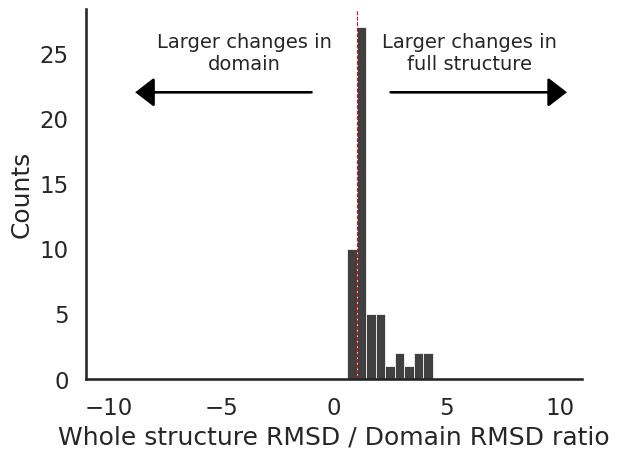

In [166]:
sns.set_context('talk')
sns.histplot(filtered_merged_rmsd_df["rmsd_between_groups"] / filtered_merged_rmsd_df["domain_rmsd_between_groups"]
             ,color='black')
sns.despine()
plt.axvline(1,ls='--',color='red',lw='0.75')
plt.ylabel("Counts")
plt.xlabel(r"Whole structure RMSD / Domain RMSD ratio")
plt.xlim(-11,11)

#
plt.text(-4, 25, "Larger changes in\ndomain",fontsize=14, horizontalalignment='center',
        verticalalignment='center')
plt.arrow(2.5, 22, 7, 0, width=0.0005, head_width=2, head_length=0.75, **{'color':'black'})


#
plt.text(6,  25, "Larger changes in\nfull structure",fontsize=14,horizontalalignment='center',
        verticalalignment='center')
plt.arrow(-1, 22, -7, 0, width=0.0005, head_width=2, head_length=0.75, **{'color':'black'})

plt.savefig(out_path / "ratio_whole_to_domain.pdf",dpi=150,bbox_inches='tight')

In [87]:
rmsd_melted_df = pd.melt(filtered_merged_rmsd_df, 
                    id_vars=['protein_x', 'residue_x', 'protein_y', 'residue_y'], 
                    value_vars=[
                        'rmsd_between_groups', 'domain_rmsd_between_groups', 
                        'rmsd_within_phospho', 'domain_rmsd_within_phospho', 
                        'rmsd_within_nonphospho', 'domain_rmsd_within_nonphospho'],
                    var_name='rmsd_type', value_name='rmsd_value')

# Create a new column that identifies whether it's a domain RMSD or not
rmsd_melted_df['is_domain'] = rmsd_melted_df['rmsd_type'].apply(
    lambda x: 'Domain' if 'domain' in x else 'Non-domain'
)


rmsd_melted_df['rmsd_measure'] = rmsd_melted_df['rmsd_type'].replace({
    'rmsd_between_groups': 'Between Groups',
    'domain_rmsd_between_groups': 'Between Groups',
    'rmsd_within_phospho': 'Within Phospho',
    'domain_rmsd_within_phospho': 'Within Phospho',
    'rmsd_within_nonphospho': 'Within Non-phospho',
    'domain_rmsd_within_nonphospho': 'Within Non-phospho'
})

In [170]:
rmsd_melted_df_whole = rmsd_melted_df.loc[rmsd_melted_df["is_domain"]=="Non-domain"]

/tmp/ipykernel_203557/318431586.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax = sns.stripplot(data=rmsd_melted_df_whole, x='rmsd_value', y='rmsd_measure',


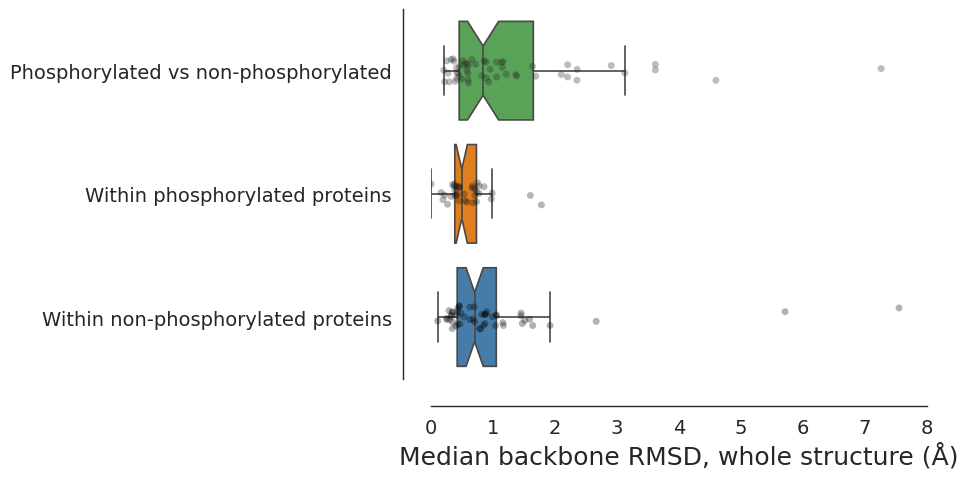

In [177]:
# Boxplot with all comparisons
sns.set_style('white')
sns.set_context('paper',rc={"xtick.labelsize":14,"ytick.labelsize":14})
ax = sns.boxplot(data=rmsd_melted_df_whole, x='rmsd_value',y='rmsd_measure',
                 orient="h", notch=True, showfliers = False,palette=color_palette)
ax = sns.stripplot(data=rmsd_melted_df_whole, x='rmsd_value', y='rmsd_measure',
                   orient="h",palette='dark:black',alpha=0.3,jitter=True)

ax.set_yticklabels(["Phosphorylated vs non-phosphorylated","Within phosphorylated proteins","Within non-phosphorylated proteins"])
ax.set_xlabel("Median backbone RMSD, whole structure (Å)",fontsize=18)

ax.set_ylabel("")

plt.xlim(0,8)
sns.despine(offset=20)
plt.savefig(out_path / "boxplot_groups_domain_whole_structure.pdf",dpi=150,bbox_inches='tight')

/local/home/mcorrea/miniconda3/envs/general/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


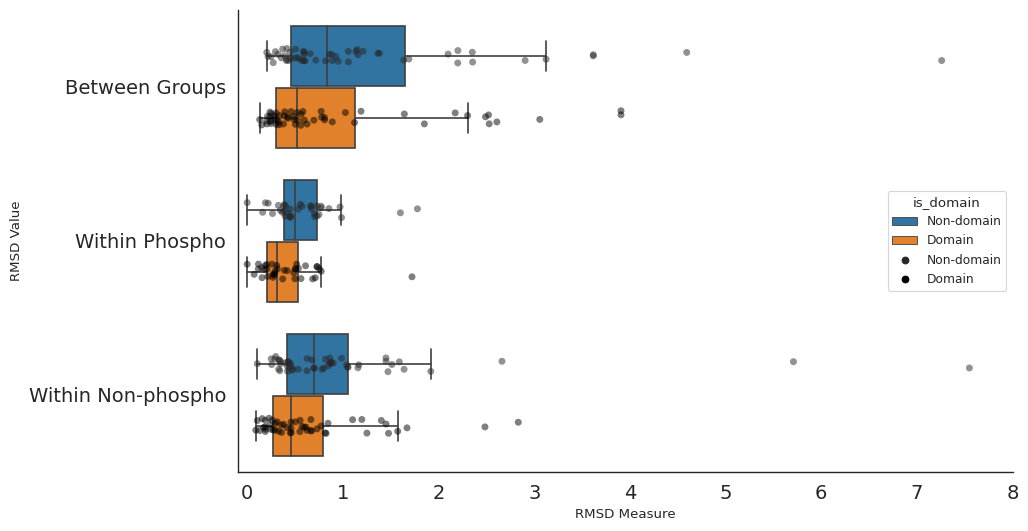

In [97]:
# Now plot using seaborn
plt.figure(figsize=(10, 6))
ax = sns.boxplot(y='rmsd_measure', x='rmsd_value', hue='is_domain', data=rmsd_melted_df,
                 showfliers=False)
ax = sns.stripplot(y='rmsd_measure', x='rmsd_value', hue='is_domain', data=rmsd_melted_df,
                  alpha=0.5, jitter=True,color='black', dodge=True)



plt.ylabel('RMSD Value')
plt.xlabel('RMSD Measure')
plt.xlim(-0.1, 8)
sns.despine()